### ДЗ №2 Файл titanicdf.csv, задачи:
#### 1. Предобработать данные (пропуски, замена текста, дубликаты и т.д)
#### 2. Использовать для классификации sklearn.ensemble.RandomForestClassifier
#### 3. Подобрать лучшие гиперпараметры (n_estimators, criterion, max_depth)
####         n_estimators - The number of trees in the forest
####         criterion - Функция измерения качества разделения
####         max_depth - Максимальная глубина дерева. Если None, то узлы расширяются до тех пор, пока все листья не станут чистыми или пока все листья не будут содержать выборок меньше, чем min_samples_split.
#### 4. Провести кроссвалидацию модели
#### 5. Оценить метрики бинарной классификации (Precision, recall, f1)
#### 6. Построить ROC-кривую для оценки качества классификатора

In [300]:
import pandas as pd
import re # для работы с регулярными выражениями
from nltk.corpus import stopwords # импорт стоп слов (предлоги и часто встречающиеся)

# метод для обучения модели
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# метод для разделения dataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import fbeta_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [525]:
df = pd.read_csv('titanicdf.csv')

### Смотрим инф-ю по датасету

In [527]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [528]:
# пропуски в % от общего кол-ва по полю
for col in df.columns:
  print(col, round(df[col].isna().sum() / df.shape[0] *100,2))

PassengerId 0.0
Survived 0.0
Pclass 0.0
Name 0.0
Sex 0.0
Age 19.87
SibSp 0.0
Parch 0.0
Ticket 0.0
Fare 0.0
Cabin 77.1
Embarked 0.22


In [529]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [530]:
df.Embarked.value_counts(normalize=True)

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

### Работаем с данными

In [531]:
# смотрим наличие дубликатов
df.duplicated().sum()

0

In [576]:
titanic_df = df.copy()

# принудительно присваиваем полю Age медианное значение по Pclass и Sex
titanic_df_age = titanic_df.groupby(['Pclass', 'Sex'], as_index=False)\
            .agg({'Age':'mean'})\
            .sort_values('Age',ascending=False)

titanic_df = titanic_df.merge(titanic_df_age, how='left', on = ['Pclass', 'Sex'])
titanic_df = titanic_df.rename(columns = {'Age_y':'Age'})
del titanic_df['Age_x']

# удаляем строчки с null по полю Embarked (таких всего 2)
titanic_df = titanic_df[~titanic_df.Embarked.isna()]

# df.dropna(inplace=True)

In [577]:
# добавляем поле молодёж/не молодёж
def check_age_for_molodezh(titanic_df):
  if titanic_df.Age <= 35:
    return 1
  else:
    return 0

In [578]:
# добавляем поле группировку по десятилетиям
def check_age_for_ten_years(titanic_df):
    return titanic_df.Age // 10 * 10

In [579]:
titanic_df['youth'] = titanic_df.apply(check_age_for_molodezh,axis=1)
titanic_df['youth_10'] =titanic_df.apply(check_age_for_ten_years,axis=1)

In [580]:
titanic_df = pd.get_dummies(data = titanic_df, columns=['Pclass', 'Sex', 'Embarked'])

In [581]:
titanic_df = titanic_df[['Survived', 'Age', 'Fare', 'youth', 'Embarked_S']]

In [582]:
titanic_df.head(3)

,Survived,Age,Fare,youth,Embarked_S
0,0,26.507589,7.2500,1,1
1,1,34.611765,71.2833,1,0
2,1,21.750000,7.9250,1,1


In [583]:
# x - все кроме таргета; y - таргет
# x = titanic_df.drop('Survived',axis = 1)
# y = titanic_df['Survived']

x = titanic_df.drop('Embarked_S',axis = 1)
y = titanic_df['Embarked_S']

# делим set на обучающую (x) и тестовую части (y)
X_train, X_test, y_train, y_test = train_test_split(x ,y ,test_size = 0.25 ,random_state = 1904)
# метод RandomForestClassifier
clf = RandomForestClassifier()
model = clf.fit(X_train, y_train)
pred = model.predict(X_test)

print('Accuracy:', accuracy_score(y_test, pred))
print('Precision:', precision_score(y_test, pred))
print('Recall:', recall_score(y_test, pred))
print('F1:', f1_score(y_test, pred))

Accuracy: 0.8385650224215246
Precision: 0.8974358974358975
Recall: 0.875
F1: 0.8860759493670887


# Гиперпараметры

In [586]:
%%time
test_deep = []
for deep in range (1, 31):
  for est in range (10, 40):
    clf = RandomForestClassifier(max_depth = deep, n_estimators = est)
    model = clf.fit(X_train, y_train)
    pred = model.predict(X_test)
    test_deep.append([deep, est, f1_score(y_test, pred),recall_score(y_test, pred)])

Wall time: 41.6 s


In [587]:
test_deep = pd.DataFrame(test_deep)
test_deep.columns = ['tree_depth','est','f1_score','recall_score']

test_deep.sort_values(by = 'f1_score',ascending = False).head(5)

,tree_depth,est,f1_score,recall_score
317,11,27,0.913580,0.92500
290,10,30,0.910769,0.92500
225,8,25,0.910769,0.92500
276,10,16,0.909657,0.91250
261,9,31,0.909091,0.90625


# GridSearch

In [588]:
%%time
tree_para = {'criterion':['gini','entropy'],
             'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
             'n_estimators':[1,2,3,4,5,6,7,8,9,10,20,30,40,50]}

Wall time: 0 ns


In [589]:
%%time
clf_gs = GridSearchCV(RandomForestClassifier(), tree_para, cv=10, scoring = 'precision')
clf_gs.fit(X_train, y_train)

Wall time: 2min 30s


GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30,
                                          40, 50]},
             scoring='precision')

In [590]:
clf_gs.best_params_

{'criterion': 'gini', 'max_depth': 90, 'n_estimators': 2}

### New model

In [591]:
model_new = RandomForestClassifier(**clf_gs.best_params_)
model_new.fit(X_train,y_train)
new_pred = model_new.predict(X_test)

print('Accuracy:',accuracy_score(y_test, new_pred))
print('Precision:',precision_score(y_test, new_pred))
print('Recall:',recall_score(y_test, new_pred))
print('F1:',f1_score(y_test, new_pred))

# Метрики до подбора гиперпараметров
    # Accuracy: 0.8385650224215246
    # Precision: 0.8974358974358975
    # Recall: 0.875
    # F1: 0.8860759493670887

Accuracy: 0.8116591928251121
Precision: 0.8986486486486487
Recall: 0.83125
F1: 0.8636363636363638


### После подстановки гиперпараметров, метрики Accuracy, Recall, F1 снизились.....

### ROC-AUC

In [592]:
pred_proba_new = model_new.predict_proba(X_test)[:,1]
fpr, tpr, treshold = roc_curve(y_test, pred_proba_new)
tree_auc_new = roc_auc_score(y_test, pred_proba_new)
print('RandomForestClassifier: ROC AUC=%.3f' % (tree_auc_new))

RandomForestClassifier: ROC AUC=0.808


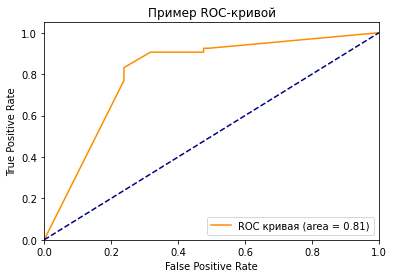

In [593]:
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr,  color = 'darkorange', label = 'ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc = "lower right")
plt.show()

# Кросс-валидация

In [594]:
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
scores = cross_val_score(model_new, X_train, y_train, cv=cv, scoring='precision')

In [595]:
scores.mean()

0.8696608997427242

In [596]:
scores

array([0.82905983, 0.87155963, 0.87719298, 0.9245283 , 0.86238532,
       0.87903226, 0.87394958, 0.87401575, 0.82352941, 0.88135593])